In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['xtick.labelsize'] = '16'
plt.rcParams['ytick.labelsize'] = '16'
plt.rcParams['axes.labelsize'] = '18'
plt.rcParams['axes.titlesize'] = '18'

nba = pd.read_csv('nba_2021-2022_stats.csv')

You guys asked for some NBA data, so I thought that we could do a deep dive into some of that. We're going to get to fitting models to data in bit, but first, let's just take a look at our new dataset.

In [5]:
nba

,Rk,Player,Pos,Age,Tm,G,MP,FGP,Distance,2P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,C,22,TOR,73,1725,0.439,10.2,0.468,...,0.595,146,327,473,82,37,41,84,151,664
1,2,Steven Adams,C,28,MEM,76,1999,0.547,2.9,0.548,...,0.543,349,411,760,256,65,60,115,153,528
2,3,Bam Adebayo,C,24,MIA,56,1825,0.557,7.0,0.562,...,0.753,137,427,564,190,80,44,148,171,1068
3,4,Santi Aldama,PF,21,MEM,32,360,0.402,12.0,0.560,...,0.625,33,54,87,21,6,10,16,36,132
4,5,LaMarcus Aldridge,C,36,BRK,47,1050,0.550,12.3,0.578,...,0.873,73,185,258,42,14,47,44,78,607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,601,Thaddeus Young,PF,33,TOR,26,475,0.465,10.1,0.495,...,0.481,40,75,115,45,31,11,22,43,164
808,602,Trae Young,PG,23,ATL,76,2652,0.460,16.5,0.512,...,0.904,50,234,284,737,72,7,303,128,2155
809,603,Omer Yurtseven,C,23,MIA,56,706,0.526,5.8,0.547,...,0.623,85,209,294,49,17,20,41,84,299
810,604,Cody Zeller,C,29,POR,27,355,0.567,3.7,0.593,...,0.776,50,75,125,22,8,6,19,56,140


The first few columns give us some basic information about players, including their team, age, position, and number of minutes played. The next few columns tell us the average distance of their shot, and then we have a few columns that tell us the fraction of shots that players made from different distances (so 0-3 feet, 3-10 feet, etc.). Then, we have columns about the number of shots attempted (both 3P and 2P), total number of shots attempted, free throws, rebounds, assists, steals, blocks, turnovers, fouls, and finally, points. Tons of information available to us, which is great! 

Today, we're mostly going to be thinking about the relationship between shot distance and field goal percentage. Because we want to make sure we're dealing with guys who have taken enough shots. Let's restrict ourselves to people who have shot the ball at least 100 times in the season. Some players are also listed multiple times (because they played on multiple teams), let's remove them the individual team stats and just take their total stats.

In [6]:
nba_new = nba.query('FGA>100').dropna()

nba_new = nba_new.drop_duplicates(subset='Player')

nba_new

,Rk,Player,Pos,Age,Tm,G,MP,FGP,Distance,2P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,C,22,TOR,73,1725,0.439,10.2,0.468,...,0.595,146,327,473,82,37,41,84,151,664
1,2,Steven Adams,C,28,MEM,76,1999,0.547,2.9,0.548,...,0.543,349,411,760,256,65,60,115,153,528
2,3,Bam Adebayo,C,24,MIA,56,1825,0.557,7.0,0.562,...,0.753,137,427,564,190,80,44,148,171,1068
3,4,Santi Aldama,PF,21,MEM,32,360,0.402,12.0,0.560,...,0.625,33,54,87,21,6,10,16,36,132
4,5,LaMarcus Aldridge,C,36,BRK,47,1050,0.550,12.3,0.578,...,0.873,73,185,258,42,14,47,44,78,607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,595,Christian Wood,C,26,HOU,68,2094,0.501,13.0,0.570,...,0.623,110,576,686,155,54,65,126,171,1218
799,597,Delon Wright,SG,29,ATL,77,1452,0.454,14.1,0.510,...,0.857,50,170,220,188,93,19,45,56,342
805,601,Thaddeus Young,PF,33,TOT,52,845,0.518,7.7,0.554,...,0.469,80,128,208,104,54,18,52,81,322
808,602,Trae Young,PG,23,ATL,76,2652,0.460,16.5,0.512,...,0.904,50,234,284,737,72,7,303,128,2155


In [14]:
nba_new['ORB'] + nba_new['DRB']

0      473
1      760
2      564
3       87
4      258
      ... 
797    686
799    220
805    208
808    284
809    294
Length: 390, dtype: int64

Now, let's take a look at how the average distance of a player's shot is related to their field goal percentage. Before we plot, what do we expect this to look like?

Text(0, 0.5, 'Field Goal Percentage')

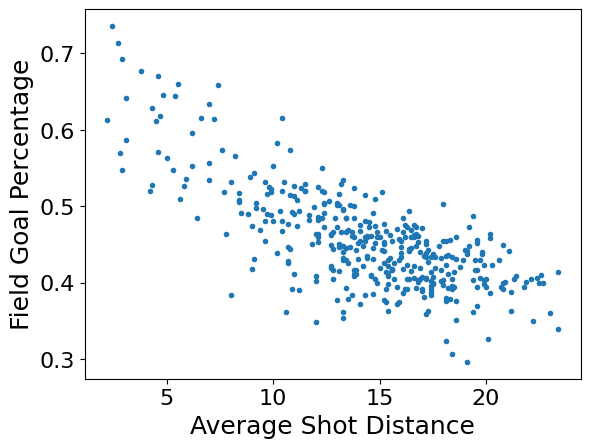

In [15]:
plt.plot(nba_new['Distance'], nba_new['FGP'], '.')
plt.xlabel('Average Shot Distance')
plt.ylabel('Field Goal Percentage')

Just as a quick aside, I noticed a few guys that have a very high field goal percentage relative to how far they're shooting from on average. See:

Text(0, 0.5, 'Field Goal Percentage')

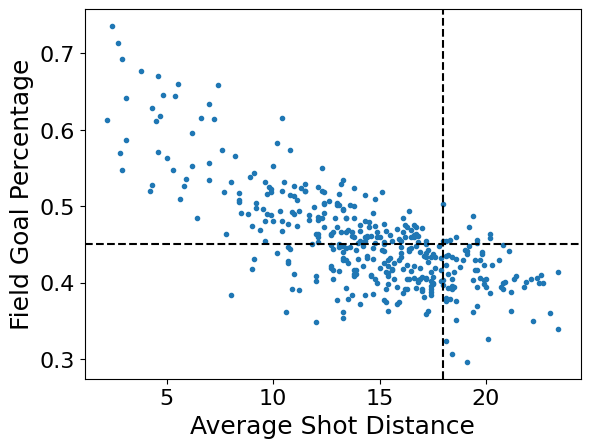

In [18]:
plt.plot(nba_new['Distance'], nba_new['FGP'], '.')
plt.axvline(18, color='black', ls='--')
plt.axhline(0.45, color='black', ls='--')
plt.xlabel('Average Shot Distance')
plt.ylabel('Field Goal Percentage')

How can we find out who these players are?

In [20]:
nba_new.sort_values('FGP', ascending=False)

,Rk,Player,Pos,Age,Tm,G,MP,FGP,Distance,2P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
789,589,Robert Williams,C,24,BOS,61,1804,0.736,2.4,0.738,...,0.722,238,350,588,121,56,134,63,137,607
257,195,Rudy Gobert,C,29,UTA,66,2120,0.713,2.7,0.718,...,0.690,241,727,968,72,45,137,119,176,1027
241,181,Daniel Gafford,C,23,WAS,72,1444,0.693,2.9,0.695,...,0.699,155,252,407,68,30,99,65,170,677
9,8,Jarrett Allen,C,23,CLE,56,1810,0.677,3.8,0.688,...,0.708,192,410,602,92,44,75,94,97,904
605,457,Dwight Powell,C,30,DAL,82,1798,0.671,4.6,0.703,...,0.783,173,231,404,97,37,39,64,220,717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,70,Armoni Brooks,SG-PG,23,TOT,54,844,0.339,23.4,0.600,...,0.857,20,83,103,62,28,11,27,74,288
343,257,Elijah Hughes,SG-SF,23,TOT,36,434,0.326,20.1,0.449,...,0.778,6,52,58,22,14,8,17,39,126
46,39,Kent Bazemore,SF,32,LAL,39,545,0.324,18.1,0.271,...,0.765,13,56,69,34,25,9,21,70,132
64,53,Keljin Blevins,SF,26,POR,31,349,0.306,18.4,0.333,...,0.545,16,29,45,19,13,1,17,29,95


Now, let's use what we learned last time to fit a line to this data.

In [37]:
from scipy.stats import linregress

fit = linregress(nba_new['Distance'], nba_new['FGP'])

fit

LinregressResult(slope=-0.011339670500790287, intercept=0.6175850412390866, rvalue=-0.7457115766337237, pvalue=2.0408483471343424e-70, stderr=0.00051435531017539, intercept_stderr=0.007672203302037271)

Now, let's plot our fit!

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

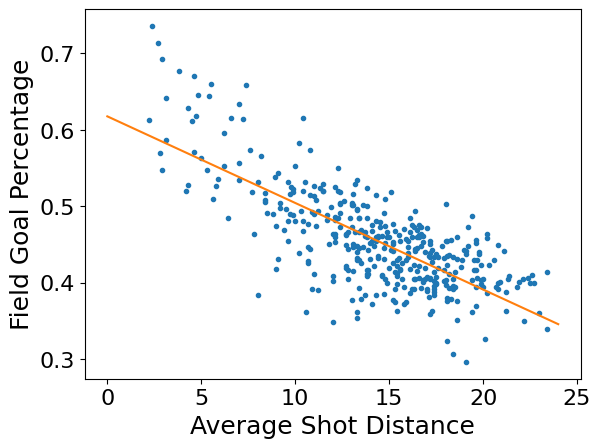

In [33]:
distance_arr = np.arange(0, 25)

fgp_arr = fit.slope * distance_arr + fit.intercept

plt.plot(nba_new['Distance'], nba_new['FGP'], '.')
plt.plot(distance_arr, fgp_arr)
plt.xlabel('Average Shot Distance')
plt.ylabel('Field Goal Percentage')

distance_arr

This fit looks pretty good! But I wouldn't say that it's perfect. It looks to me like the shortest shots with the highest percentage break a bit from this linear trend--you can see that they're higher than what the line predicts, and they don't seem to be scattering evenly around the line. This could mean that a linear model might not be the right way to fit this data. But we can't decide by eye whether or not our models fit well; we want a way to quantitatively say whether or not one model is better than another. To do this, we need to evaluate the "goodness of fit", which we can do with a statistic called $\chi^2$ (pronounced like the end of "sky", and chi is squared). For a single data point, $\chi$ is defined as follows:

# $\chi_i = \frac{y_i - f(P,x_i)}{\sigma_i}$

Put into words, what we want to do is take the real data that we observe at each point, and compare it to what the model (fit for parameters "P") predicts the data should be, and divide it all by the uncertainty in our measurement. If $\chi$ is equal to 0, that means that the data predicts the model perfectly at that point. If $chi$ is bigger than zero, it means that the model underpredicts the data, and if $\chi$ is less than 0, then the data underpredicts the model.

We'll want to measure chi for our data, but first we need to know what our uncertainty is. You can take my word for it that for measurements like the Field Goal Percentage, the uncertainty is "binomial", meaning that the uncertainty can be approximated as:

# $\sigma = \sqrt{\frac{P \times (1-P)}{N}}$

Where P is the measured fraction (in our case, the field goal percentage) and N is the number of samples (in this case, the number of shots that a player took). What happens to $\sigma$ if the number of samples gets bigger? 

We can calculate that for our data like so:

In [34]:
sigma = np.sqrt( nba_new['FGP'] * (1 - nba_new['FGP'])  / nba_new['FGA'])

sigma

0      0.020209
1      0.025403
2      0.018398
3      0.042675
4      0.023246
         ...   
797    0.016874
799    0.030356
805    0.030297
808    0.012684
809    0.031771
Length: 390, dtype: float64

Now, let's plot our data with the errorbars that we measured:

Text(0, 0.5, 'Field Goal Percentage')

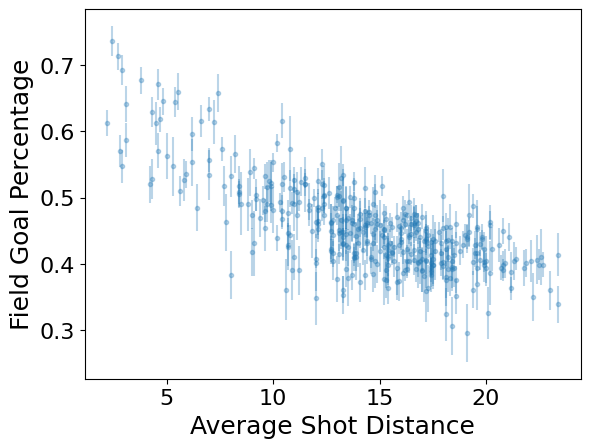

In [35]:
plt.errorbar(nba_new['Distance'], nba_new['FGP'], sigma, fmt='.', alpha=0.3)
plt.xlabel('Average Shot Distance')
plt.ylabel('Field Goal Percentage')

Now, let's measure $\chi$ for each point. Before we do that, I want to introduce a slightly different way to fit the data, one that accounts for how certain we are in each point. For some data points, we can be more confident in the measurement than we can in the other measurement, and we can take advantage of this in our fitting by weighting our measurements by $\frac{1}{\sigma^2}$. The scipy linregress function can't do this, but numpy has a really nice built in method called "polyfit" that can. 

We want to once again fit a line to data, with a slope and an intercept. These lines are also sometimes called "degree 1" polynomials, because they depend on x linearly. We can use the polyfit function below to measure the slope and intercept for this function, giving "1" as an argument for the degree since we want to fit a line, and giving w=1/sigma^2 because we want use the uncertainty to weight our points:

In [36]:
poly1 = np.polyfit(nba_new['Distance'], nba_new['FGP'], 1, w=1/sigma**2)
poly1

array([-0.01152172,  0.62849272])

You'll notice that the slope and intercept here are a little bit different than what we measured before. This is because now, the people who shot the ball less times are being less utilized in the fit than the guys who shot it more. Now, let's plot our new fit. We can do this by using the "poly1d" function, which will return us a new function that we can then use to plot.

Text(0, 0.5, 'Field Goal Percentage')

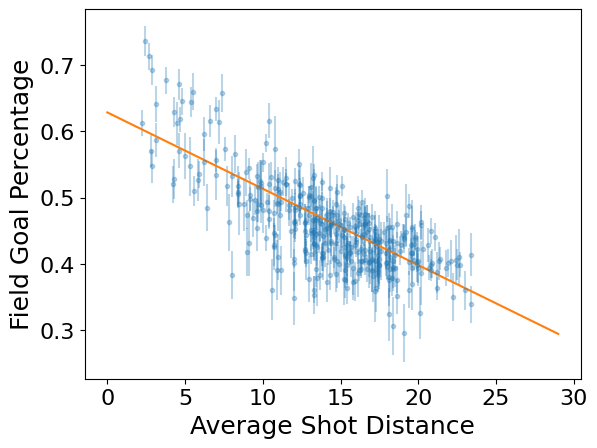

In [41]:
poly1_function = np.poly1d(poly1)

distance_arr = np.arange(0, 30)

plt.errorbar(nba_new['Distance'], nba_new['FGP'], sigma, fmt='.', alpha=0.3)
plt.plot(distance_arr, poly1_function(distance_arr))
plt.xlabel('Average Shot Distance')
plt.ylabel('Field Goal Percentage')

The nice thing about this approach is that this new poly1_function can just be evaluated at any point. Try reading off the plot above what you expect the field goal percentage to be for an average shot distance, and then let's check to see what it looks like.

In [42]:
poly1_function(30)

0.28284117726985786

The cool thing about this is that it's now really easy to measure $\chi$, because we now have a function that can super easily give us the value of FGP for a given shot distance. Let's do that in the cell below, and then plot it.

Text(0.5, 0, 'Distance')

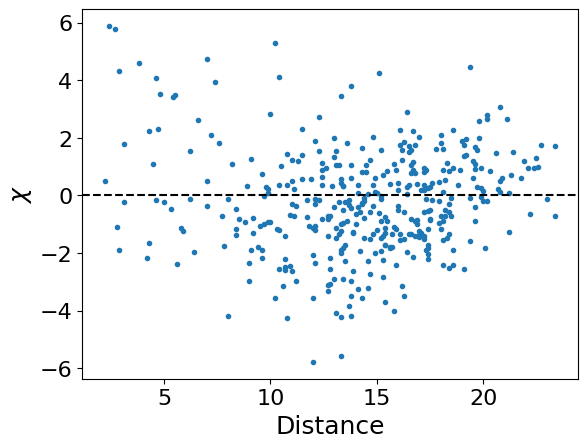

In [43]:
chi1 = (nba_new['FGP'] - poly1_function(nba_new['Distance']))/sigma

plt.plot(nba_new['Distance'], chi1, '.')
plt.axhline(0, color='black', ls='--')
plt.ylabel(r'$\chi$')
plt.xlabel('Distance')

My eyes are drawn to the top right of that plot, where we can see that there are lots of points with $\chi=4/5/6$, but none with -4/-5/-6. This tells us that what we saw by eye was true--our model underpredicts the field goals made by the guys shooting from the shortest distances.

Now, we're gonna measure $\chi^2$, which is a metric for how good the fit is. We can do this with a simple sum now that we've measured each of the individual $\chi$ values:

# $\chi^2 = \sum\limits_{i} \chi^2_i$

Which looks like this in python:

In [44]:
chi1_squared = np.sum(chi1**2)

chi1_squared

1314.2020510734185

In a vaccum, that number is kind of meaningless, but we can also use a statistic $\chi^2_\nu$, known as the "reduced chi squared", which is equal to:

# $\chi^2_\nu = \frac{\chi^2}{N_\mathrm{data} - N_\mathrm{parameters}}$

The number of data points is easy, that's just the number of points that we are fitting. The number of free parameters in the model is the number of parameters that we are "fitting for". So in the case of our linear model with a slope and intercept, P is 2. If everything else stays the same, what will happen to $\chi^2_\nu$ if the number of parameters gets very large? Keep that in mind as we move forward!

A good rule of thumb is that the closer to 1 that the reduced $\chi^2$ is, the better our fit is. Let's measure it for our linear fit.

In [45]:
reduced_chi1_squared = chi1_squared / (len(chi1) - 2)

reduced_chi1_squared

3.387118688333553

That is a pretty low value, and it indicates that our fit is pretty good! But we can see by eye that it's not perfect, so what if we try to fit with a different kind of model instead? The most natural thing to try if a line isn't working would be to try a polynomial, which is just a higher order line. For example, a second order polynomial would look like:

# $y = ax^2 + bx +c$

where a, b, and c are free parameters. A third order polynomial would look like:

# $y = ax^3 + bx^2 + cx +d$

And so on to infinity. The nice thing about the approach we've been taking with np.polyfit is that to change the order of the polynomial, all we have to do is change the degree argument like this, to get a fit for all 3 of these parameters.

In [46]:
poly2 = np.polyfit(nba_new['Distance'], nba_new['FGP'], 2, w=1/sigma**2)
poly2_function = np.poly1d(poly2)

poly2

array([ 5.68281442e-04, -2.67486474e-02,  7.22111787e-01])

Let's see what this new fit looks like compared to our old one.

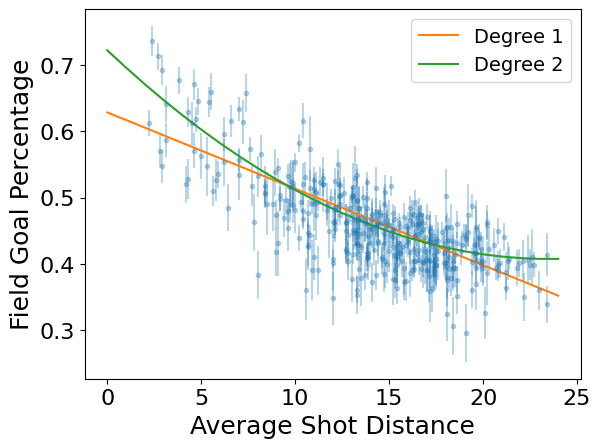

In [47]:
distance_arr = np.arange(0, 25)

plt.errorbar(nba_new['Distance'], nba_new['FGP'], sigma, fmt='.', alpha=0.3)
plt.plot(distance_arr, poly1_function(distance_arr), label='Degree 1')
plt.plot(distance_arr, poly2_function(distance_arr), label='Degree 2')

plt.xlabel('Average Shot Distance')
plt.ylabel('Field Goal Percentage')
plt.legend(fontsize=14)

By eye, this looks better! But how do we check? That's where $\chi^2_\nu$ comes in. We can compare the reduced $\chi^2$ between the two models and see which one is lower. If our new model does significantly better than the old one, we say that it is a better fit to the data. Let's try below. Notice that the number of parameters this time is 3, not 2, because we added one more free parameter.

In [48]:
chi2 = (nba_new['FGP'] - poly2_function(nba_new['Distance']))/sigma

chi2_squared = np.sum(chi2**2)

reduced_chi2_squared = chi2_squared / (len(chi2) - 3)

print(reduced_chi2_squared)

3.013331116760224


The value before was 3.38, and now our value is 3. So we've made our fit better by adding the additional parameter. Why not go further and fit with an order 10 polynomial, though? Let's try below to see.

In [49]:
poly10 = np.polyfit(nba_new['Distance'], nba_new['FGP'], 10, w=1/sigma**2)
poly10_function = np.poly1d(poly10)

poly10

array([ 3.17604641e-12,  6.97817146e-12, -2.63974253e-08,  1.77177217e-06,
       -5.64429709e-05,  1.04670265e-03, -1.19797646e-02,  8.49346671e-02,
       -3.58385606e-01,  7.89822501e-01, -2.91068537e-02])

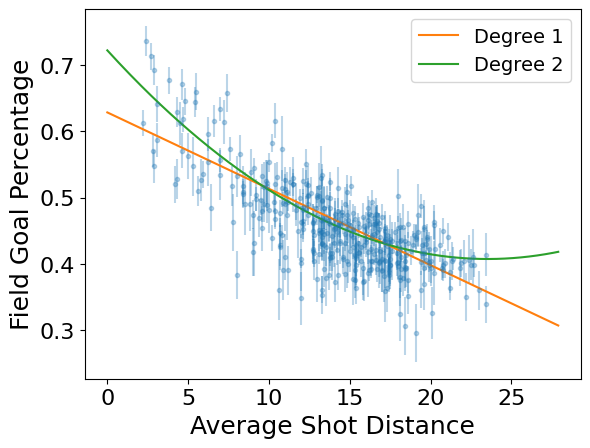

In [58]:
distance_arr = np.arange(0, 28, 0.1)

plt.errorbar(nba_new['Distance'], nba_new['FGP'], sigma, fmt='.', alpha=0.3)
plt.plot(distance_arr, poly1_function(distance_arr), label='Degree 1')
plt.plot(distance_arr, poly2_function(distance_arr), label='Degree 2')
# plt.plot(distance_arr, poly10_function(distance_arr), label='Degree 10')

plt.xlabel('Average Shot Distance')
plt.ylabel('Field Goal Percentage')
plt.legend(fontsize=14)

Well, that looks weird, right? Adding new parameters to your model is dangerous! It will always get a better fit to the data, but there are two downsides:

1) Adding extra parameters makes extrapolating the model outside of the range of the data very dangerous. In our linear model and quadratic model, we can get a pretty good guess for how somebody who shoots outside our range of data will perform, but the order 10 model actually says that somebody will shoot 100% if they consistently shoot from 27 feet. We know that doesn't make sense!
2) The addition of these extra models doesn't actually improve our reduced $\chi^2$ value! Let's confirm that below:

In [56]:
chi10 = (nba_new['FGP'] - poly10_function(nba_new['Distance']))/sigma

chi10_squared = np.sum(chi10**2)

reduced_chi10_squared = chi10_squared / (len(chi10) - 10)

print(reduced_chi10_squared)

3.056979416632682


We actually made the reduced $\chi^2$ higher by adding those extra parameters! So we haven't made things any better, and we've needlessly complicated our model. In general, it's good to fit with as few parameters as possible to get a good fit.

# Activity: Exploring the NBA dataset

Play around with a correlation of your choice in the NBA data set and try fitting a line to it. Does it look like a linear fit does the job? If not, what does look like it fits the data well?

In [60]:
nba_new.columns.values

array(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'FGP', 'Distance',
       '2P', '0-3', '3-10', '10-16', '16-3P', '3P', '3PA', '2PA', 'FGA',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS'], dtype=object)

In [65]:
nba_new[nba_new['Player']=='Stephen Curry'][['FGA']]

,FGA
159,1224


In [66]:
nba_new[nba_new['Player']=='Seth Curry'][['FGA']]

,FGA
156,739
